# Replication of paper "Approximate Bayesian computational methods" (2011)

In [1]:
using Distributions, StatsPlots, Plots, StatsBase, LinearAlgebra
using LaTeXStrings
using SymPy
using VegaLite
using DataFrames
pyplot()

Plots.PyPlotBackend()

### **Alorithm 1** - Likelihood-free rejection sampler 1
Let's use sampling from Uniform with binomial likelihood function to illustrate this algorithm.

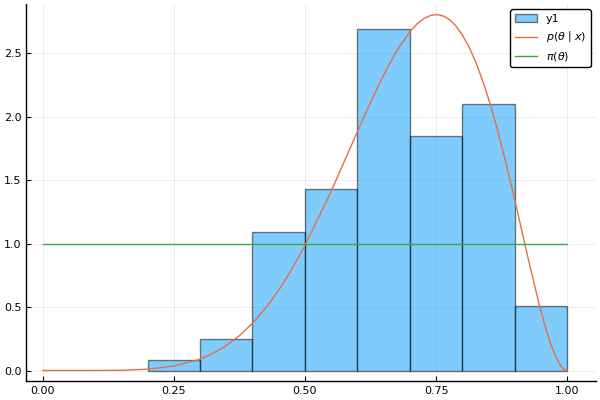

In [175]:
n, x = 8, 6
N = 1000

# Sample θ' from prior π(θ)
# Generate z from p(.|θ')
theta_s = rand(Beta(1,1),N)
z       = rand.(Binomial.(n,theta_s))
theta_a = theta_s[z .== x];
v = collect(range(0, stop=1, length=N));

histogram(theta_a,normalize=true,alpha=0.5)
plot!(Beta(x+1,n-x+1),label=L"p(\theta \mid x)")
plot!(Beta(1,1), label =L"\pi(\theta)")

### **Alorithm 2** - Likelihood-free rejection sampler 2

Let's write the functions for calculating the distances between the variables.

##### a) **Moving Average Model**

In [176]:
MA(current, u,t) = u[current+2] + u[current + 1] * t[2] + u[current] * t[1]

function genMA(u,t,n,N)
    z = zeros(N,n)
        for i=1:N
            z[i,:] = MA.((1:n),Ref(u[i,:]),Ref(t[i,:]))
        end
    return z
end

genMA (generic function with 1 method)

##### b) **Synthetic Dataset**
###### Moving Average model (MA)
$y_k = u_k + \sum_{i=1}^q \theta_i u_{k-i}$

$y \sim MA(q)$

$(\theta_1,\theta_2) =(0.6,0.2)$,sample size of 100.

In [181]:
using Random
Random.seed!(1)
theta = [0.6;0.2]
n     = 100
u     = randn(n+2)
y     = MA.((1:n),Ref(u),Ref(theta));
# y     = genMA(u',theta',n,1)

##### c) **Distance Functions and Suffient Statistics**

In [203]:
raw_distance(y,z)         = sqrt(sum((y-z).^2))
function autocov_distance(q,y,z)
    d = zeros(q)
    for i=1:q
       d[i] = ((autocov(y,[q],demean=false)[1] - autocov(z,[q],demean=false)[1])^2)[1]
    end
    return sqrt(sum(d))
end
# autocov_distance(q,y,z)   = sqrt(for (autocov(y,[q],demean=false)[1] - autocov(z,[q],demean=false)[1])^2)[1]

autocov_distance (generic function with 1 method)

In [258]:
function abcautocov_distance(y,z)
    ay = 0
    az = 0
    for i = 2:length(y)
        ay +=y[i]*y[i-1]
        az +=z[i]*z[i-1]
    end
    ay2 = 0
    az2 = 0
    for i = 3:length(y)
        ay2 +=y[i]*y[i-2]
        az2 +=z[i]*z[i-2]
    end
    rho = (ay - az)^2+(ay2 - az2)^2
    return rho
end
# autocov(y,demean=false)
# sum(y.^2)

abcautocov_distance (generic function with 1 method)

##### d) **Triangular Sampling**
Using rejection sampling to sample uniformly in a triangle

In [259]:
function rand_TriUniform(N=1)
    trisample = zeros(N,2)
    count = 0
    while count < N
        theta = [4*rand()-2;2*rand()-1]
        if (theta[1]>-2 && theta[1]<2) && (sum(theta)>-1) && (theta[1]-theta[2] < 1)
            count+=1
            trisample[count,:] = theta
        end
    end
    return trisample
end

rand_TriUniform (generic function with 2 methods)

##### e) **Running Algorithm 2**

In [195]:
N = 10^6        # number of trials
n = length(y) # sample size
theta_s = rand_TriUniform(N)
u       = randn(N,n+2)
z       = genMA(u,theta_s,n,N);

In [260]:
# autocov_vectorize(z)    = autocov_distance(2,y,z)
autocov_vectorize(z)    = abcautocov_distance(y,z)
dist_vectorize(z)       = raw_distance(y,z)
rho_autocov = mapslices(autocov_vectorize, z, dims =2)[:];
rho_dist    = mapslices(dist_vectorize, z, dims =2)[:];

In [261]:
epsilon10e4_autocov = quantile(rho_autocov,0.1/100)
epsilon10e4_dist    = quantile(rho_dist,0.1/100)

# zacauto = z[rho_autocov .< epsilon10e4_autocov,:];

In [262]:
theta_ac_auto = theta_s[rho_autocov .< epsilon10e4_autocov,:];
theta_ac_dist = theta_s[rho_dist    .< epsilon10e4_dist,:];

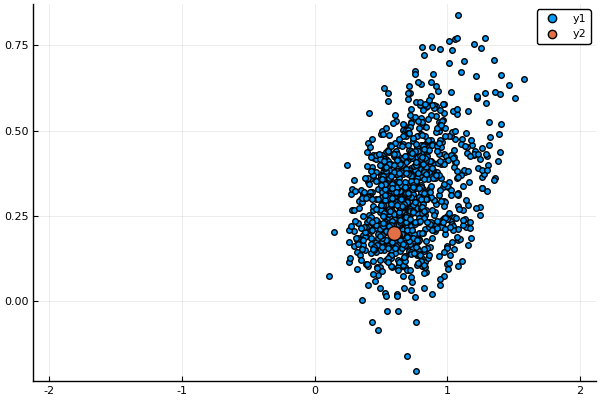

In [274]:
scatter(theta_ac_auto[:,1],theta_ac_auto[:,2],xlims=[-2,2])

# scatter!(theta_ac_dist[:,1],theta_ac_dist[:,2],xlims=[-2,2])
scatter!([theta[1]],[theta[2]],markersize=10)

In [299]:
function Ger_Simga(θ1,θ2, y)
#     θ1= 0.6
#     θ2= 0.2
    Σ = zeros(100,100)
    for i=1:length(y)
        if i == 1
            Σ[i,i]   = 1 + θ1^2 + θ2^2
            Σ[i,i+1] = θ1 + θ1*θ2
            Σ[i,i+2] = θ2
        elseif i == 2
            Σ[i,i-1] = θ1 + θ1*θ2
            Σ[i,i]   = 1 + θ1^2 + θ2^2
            Σ[i,i+1] = θ1 + θ1*θ2
            Σ[i,i+2] = θ2
        elseif i == 99
            Σ[i,i-2] = θ2
            Σ[i,i-1] = θ1 + θ1*θ2
            Σ[i,i]   = 1 + θ1^2 + θ2^2
            Σ[i,i+1] = θ1 + θ1*θ2
        elseif i == 100
            Σ[i,i-2] = θ2
            Σ[i,i-1] = θ1 + θ1*θ2
            Σ[i,i]   = 1 + θ1^2 + θ2^2
        else
            Σ[i,i-2] = θ2
            Σ[i,i-1] = θ1 + θ1*θ2
            Σ[i,i]   = 1 + θ1^2 + θ2^2
            Σ[i,i+1] = θ1 + θ1*θ2
            Σ[i,i+2] = θ2
        end
    end

    return Σ
end
θ1= 0.6
θ2= 0.2
Ger_Simga(θ1,θ2,y);

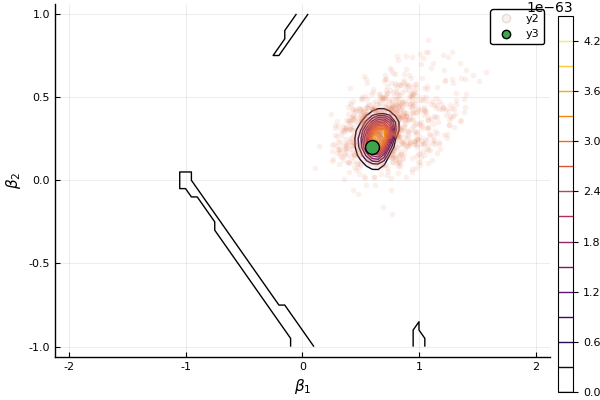

In [316]:
gθ1      = -2:0.05:2
gθ2      = -1:0.05:1
gridθ1   = repeat(reshape(gθ1, 1, :), length(gθ2), 1)
gridθ2   = repeat(gθ2, 1, length(gθ1))
mamvn(θ1,θ2) = pdf(MvNormal(zeros(100),Ger_Simga(θ2,θ1,y)),y)
Z = map(mamvn, gridθ1, gridθ2)
p1 = contour(gθ1,gθ2, mamvn, fill=false,
    xlabel=L"\beta_1", ylabel=L"\beta_2")

scatter!(theta_ac_auto[:,1],theta_ac_auto[:,2],xlims=[-2,2],alpha=0.1,markerstrokewidth=0)

# scatter!(theta_ac_dist[:,1],theta_ac_dist[:,2],xlims=[-2,2])
scatter!([theta[1]],[theta[2]],markersize=10)

In [294]:
# y = -4:0.05:1
# x = -1:0.05:4
# gridx = repeat(reshape(x, 1, :), length(y), 1)
# gridy = repeat(y, 1, length(x))
f(x,y)= exp(LogPosterior([x y]))
Z = map(f, gridx, gridy)
p1 = contour(x,y, f, fill=false,
    xlabel=L"\beta_1", ylabel=L"\beta_2")
# pdf(MvNormal(zeros(100),Ger_Simga(θ1,θ2,y)),y)

3.7318112822733235e-76